# Import

Model execution times on a 32 GB RAM, apple M2 max chip laptop:

- Hyperparameter tuning: around 1 hour.
- Cpx barometer: 2.56 seconds.
- Cpx thermometer: 2.81 seconds.
- Cpx_liquid barometer: 4.44 seconds.
- Cpx_liquid thermometer: 4.82 seconds.

In [1]:
import numpy as np
import pandas as pd  
import scipy.stats as st
import json
import joblib
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import onnxruntime as rt
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from ML_PT_Pyworkflow import*

import warnings
warnings.filterwarnings('ignore')

# Settings

In [2]:
cpx_only   = False  # True or False for Liquid
pwlt       = False # or False
output     = 'Temperature' # 'Temperature'or 'Pressure'
bias       = True  # True or False
chromium   = True      # or False
p          = 1000  # number of perturbations in test data

# Data Upload

In [3]:
df_init = Dataset.Jorgenson

Elements_Cpx = ['SiO2_Cpx', 'TiO2_Cpx', 'Al2O3_Cpx', 'FeOt_Cpx', 'MgO_Cpx', 'MnO_Cpx', 'CaO_Cpx',  'Na2O_Cpx', 'Cr2O3_Cpx']
Elements_Liq = ['SiO2_Liq', 'TiO2_Liq', 'Al2O3_Liq', 'FeOt_Liq', 'MgO_Liq', 'MnO_Liq', 'CaO_Liq',  'Na2O_Liq', 'K2O_Liq']

if cpx_only:
    columns_name = Elements_Cpx.copy()
    columns_name = columns_name if chromium else [x for x in columns_name if 'Cr' not in x]
    df = df_init[columns_name]
    sample_names = np.array(df_init['Sample_ID'])
else:
    columns_name = Elements_Cpx.copy() + Elements_Liq.copy()
    columns_name = columns_name if chromium else [x for x in columns_name if 'Cr' not in x]
    df = df_init[columns_name]
    sample_names = np.array(df_init['Sample_ID'])
    sum_liq = np.reshape(np.array(df_init[Elements_Liq].sum(axis=1)),(len(df_init),1))


Xd = df.copy()
    
if output == 'Pressure':
    yd = df_init['P_kbar']
elif output == 'Temperature':
    yd = df_init['T_C']
else:
    print('We can just menage Pressure or Temperature')

X = np.array(Xd)
y = np.array(yd)

# Model

## Settings

In [4]:
std_dev_perc = Parameters.oxide_rel_err 
#std_dev_perc = np.array([0.03,0.08,0.03,0.03,0.03,0.08,0.03,0.08,0.08])

K = Parameters.K_rel_err
#K = np.array([0.08])

if cpx_only:
    std_dev_perc = std_dev_perc if chromium else std_dev_perc[:-1]
    
else:
    std_dev_perc_temp_1 = std_dev_perc if chromium else std_dev_perc[:-1]
    std_dev_perc_temp_2 = std_dev_perc[:-1]
    std_dev_perc = np.concatenate((std_dev_perc_temp_1,std_dev_perc_temp_2,K),axis=None)

In [5]:
# Bins to manage unbalanced float numbers as output 

if output == 'Pressure':
    bins = Parameters.pressure_bins
elif output == 'Temperature':
    bins = Parameters.temperature_bins
else:
    print('We can just menage Pressure or Temperature')

## Train Test Split

In [6]:
test_size = 0.2
X_train, X_test, y_train, y_test, train_index, test_index = balanced_train_test(X,y,bins,test_size, sample_names)

In [7]:
# Rescaling input features
scaler = StandardScaler().fit(X_train) 

In [8]:
X_test_perturb, y_test_perturb, groups_test = perturbation(X_test
                                                           ,y_test
                                                           ,std_dev_perc 
                                                           ,n_perturbations=p)
if pwlt:
    X_test_perturb_s = pwlt_transformation(X_test_perturb)
    X_test_s = pwlt_transformation(X_test)
else:
    X_test_perturb_s = scaler.transform(X_test_perturb)
    X_test_s = scaler.transform(X_test)  

## Train & Validation

### Main Model: Hyperparameters fine tuning

#### n_estimators 

In [9]:
start=datetime.now() 

n_perturbations = 15
k_fold = 10
max_depth = 15

i_tot = []
j_tot = []
score_perturb_train_val_tot = []
score_train_val_tot = []

for i in [1,3,5,8,10,15,20,25,30,35,40,45,50,100,150,200,250,300,350]:
        
    model_ET_perturb, score_perturb_train_val = ET_train_validation_balanced_perturbation(X_train
                                                                                          ,y_train
                                                                                          ,std_dev_perc
                                                                                          ,bins
                                                                                          ,k_fold=k_fold
                                                                                          ,n_estimators=i
                                                                                          ,max_depth=max_depth
                                                                                          ,n_perturbations=n_perturbations
                                                                                          ,pwlt=pwlt)
    model_ET, score_train_val = ET_train_validation_balanced(X_train
                                                             ,y_train
                                                             ,bins
                                                             ,k_fold=k_fold
                                                             ,n_estimators=i
                                                             ,max_depth=max_depth
                                                             ,pwlt=pwlt)

   
    
    i_tot.append(i)
    score_perturb_train_val_tot.append(score_perturb_train_val)
    score_train_val_tot.append(score_train_val)
    
    print('i-param:',i)
    print('score-model-perturb_train_val:',score_perturb_train_val)
    print('score-model_train_val:',score_train_val)
    print('################')
    
print(datetime.now()-start)         

i-param: 1
score-model-perturb_train_val: 0.8448509673968821
score-model_train_val: 0.8306410891671782
################
i-param: 3
score-model-perturb_train_val: 0.9125805275730376
score-model_train_val: 0.9088981012784136
################
i-param: 5
score-model-perturb_train_val: 0.9225296027953711
score-model_train_val: 0.92241817015707
################
i-param: 8
score-model-perturb_train_val: 0.932013418987873
score-model_train_val: 0.9300504761444502
################
i-param: 10
score-model-perturb_train_val: 0.9339669141744364
score-model_train_val: 0.9330376695988412
################
i-param: 15
score-model-perturb_train_val: 0.9382636775657222
score-model_train_val: 0.9389176150743073
################
i-param: 20
score-model-perturb_train_val: 0.9402227160099805
score-model_train_val: 0.9404811912511276
################
i-param: 25
score-model-perturb_train_val: 0.93909669245866
score-model_train_val: 0.9415606499123171
################
i-param: 30
score-model-perturb_train_val

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


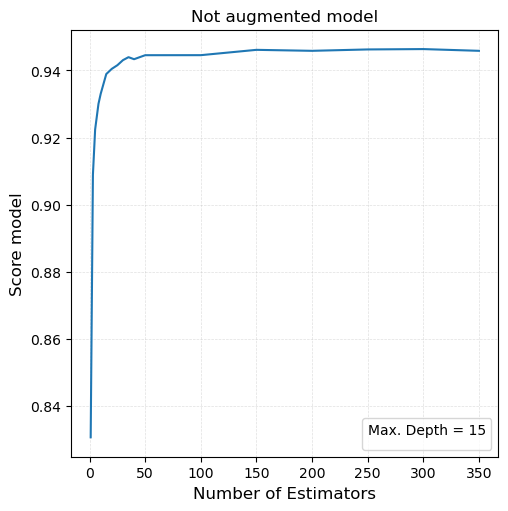

In [10]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5, 5))
sns.lineplot(x=i_tot, y=score_train_val_tot)
ax.set_xlabel('Number of Estimators', fontsize=12)
ax.set_ylabel('Score model' , fontsize=12)
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_title('Not augmented model')
ax.legend(title = 'Max. Depth = 15', loc='lower right')
ax.set_box_aspect(1)
#plt.savefig('Figures/'+'Cpx_hyperp_nTrees_NotPropModel_'+output+ ('_cpx_only' if cpx_only else '_cpx_liq') + ('_pwlr_' if pwlt else '_') +'.pdf', format='pdf')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


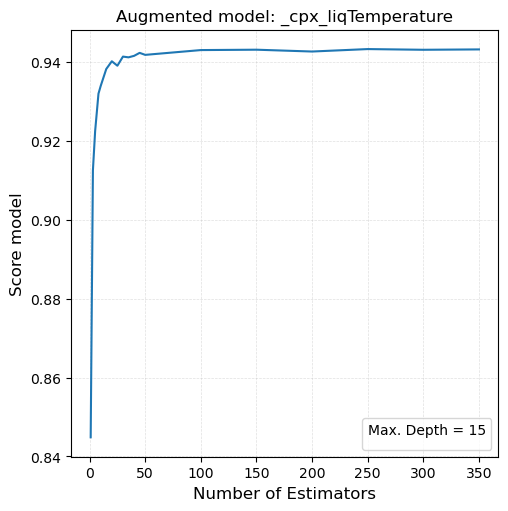

In [11]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5, 5))
sns.lineplot(x=i_tot, y=score_perturb_train_val_tot)
ax.set_xlabel('Number of Estimators', fontsize=12)
ax.set_ylabel('Score model', fontsize=12)
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_title('Augmented model: '+ ('cpx ' if cpx_only else '_cpx_liq')+output)
ax.legend(title = 'Max. Depth = 15', loc='lower right')
ax.set_box_aspect(1)
#plt.savefig('Figures/'+'Cpx_hyperp_nTrees_PropModel_'+output+ ('_cpx_only' if cpx_only else '_cpx_liq') + ('_pwlr_' if pwlt else '_') +'.pdf', format='pdf')


#### Max Depth

In [12]:
start=datetime.now() 

n_perturbations = 15
k_fold = 10
n_estimators = 200
i_tot = []
j_tot = []
score_perturb_train_val_tot = []
score_train_val_tot = []

for i in range(1,25):
    model_ET_perturb, score_perturb_train_val = ET_train_validation_balanced_perturbation(X_train
                                                                                          ,y_train
                                                                                          ,std_dev_perc
                                                                                          ,bins
                                                                                          ,k_fold=k_fold
                                                                                          ,n_estimators=n_estimators
                                                                                          ,max_depth=i
                                                                                          ,n_perturbations=n_perturbations
                                                                                          ,pwlt=pwlt)

    model_ET, score_train_val = ET_train_validation_balanced(X_train
                                                             ,y_train
                                                             ,bins
                                                             ,k_fold=k_fold
                                                             ,n_estimators=n_estimators
                                                             ,max_depth=i
                                                             ,pwlt=pwlt)


    i_tot.append(i)
    score_perturb_train_val_tot.append(score_perturb_train_val)
    score_train_val_tot.append(score_train_val)
    print('i-param:',i)
    print('score-model-perturb_train_val:',score_perturb_train_val)
    print('score-model_train_val:',score_train_val)
    print('################')
    
print(datetime.now()-start) 

i-param: 1
score-model-perturb_train_val: 0.457665902036537
score-model_train_val: 0.46844287564103454
################
i-param: 2
score-model-perturb_train_val: 0.6359275623419791
score-model_train_val: 0.6427934027559062
################
i-param: 3
score-model-perturb_train_val: 0.7514365839828093
score-model_train_val: 0.7613466906102618
################
i-param: 4
score-model-perturb_train_val: 0.8213966753475452
score-model_train_val: 0.8318551581900782
################
i-param: 5
score-model-perturb_train_val: 0.8634541487649378
score-model_train_val: 0.8704470589827065
################
i-param: 6
score-model-perturb_train_val: 0.8879495776674411
score-model_train_val: 0.8953548400270381
################
i-param: 7
score-model-perturb_train_val: 0.9033245488848827
score-model_train_val: 0.9115053000000517
################
i-param: 8
score-model-perturb_train_val: 0.9146548927850034
score-model_train_val: 0.9235257243286314
################
i-param: 9
score-model-perturb_train_val

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


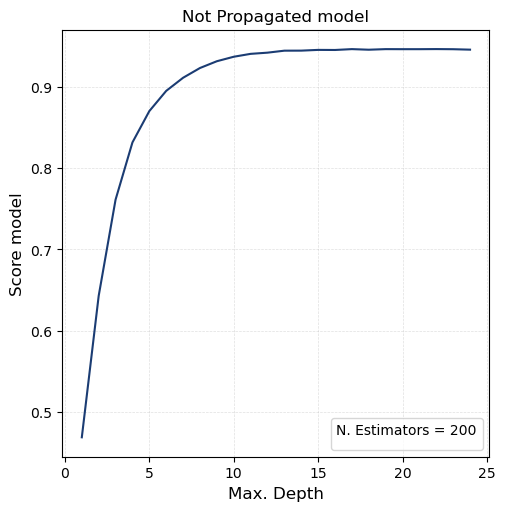

In [13]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5, 5))
sns.lineplot(x=i_tot, y=score_train_val_tot, color='#1B3C73')
ax.set_xlabel('Max. Depth', fontsize=12)
ax.set_ylabel('Score model' , fontsize=12)
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_title('Not Propagated model')
ax.legend(title = 'N. Estimators = 200', loc='lower right')
ax.set_box_aspect(1)
#plt.savefig('Figures/'+'Cpx_hyperp_maxDepth_NotPropModel'+output+ ('_cpx_only' if cpx_only else '_cpx_liq') + ('_pwlr_' if pwlt else '') +'.pdf', format='pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


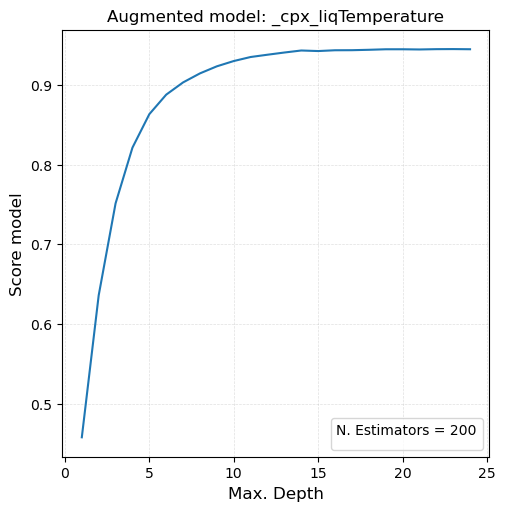

In [14]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5, 5))
sns.lineplot(x=i_tot, y=score_perturb_train_val_tot)
ax.set_xlabel('Max. Depth', fontsize=12)
ax.set_ylabel('Score model' , fontsize=12)
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_title('Augmented model: '+ ('cpx ' if cpx_only else '_cpx_liq')+output)
ax.legend(title = 'N. Estimators = 200', loc='lower right')
ax.set_box_aspect(1)
#plt.savefig('Figures/'+'Cpx_hyperp_maxDepth_PropModel_'+output+ ('_cpx_only' if cpx_only else '_cpx_liq') + ('_pwlr_' if pwlt else '_') +'.pdf', format='pdf')


#### Number of estimator and Number of new synthetic instances

In [15]:
start=datetime.now() 
num_estimators_tot = []
n_pert_tot = []
score_perturb_train_val_tot = []
score_train_val_tot = []

for j in [1,5,10,15,20]:  
    for i in range(100,340,20):
    
        score_perturb_train_val = ET_train_validation_balanced_perturbation(
                                        X_train,y_train
                                        ,std_dev_perc
                                        ,bins
                                        ,k_fold=10#10
                                        ,max_depth=15
                                        ,n_estimators=i
                                        ,n_perturbations=j)#j*5
        score_train_val = ET_train_validation_balanced(X_train,y_train
                                              ,bins,k_fold=10,n_estimators=i,max_depth=15)#10 k_fold
        num_estimators_tot.append(i)
        n_pert_tot.append(j)#*5
        score_perturb_train_val_tot.append(score_perturb_train_val)
        score_train_val_tot.append(score_train_val)
        
        print('n_estimators:',i,', n-pert:', j)#j*5
        print('score-model-perturb_train_val:',score_perturb_train_val)
        print('score-model_train_val:',score_train_val)
        print('################')
print(datetime.now()-start) 

n_estimators: 100 , n-pert: 1
score-model-perturb_train_val: (ExtraTreesRegressor(max_depth=15), 0.9368854558688877)
score-model_train_val: (ExtraTreesRegressor(max_depth=15), 0.9455330529788016)
################
n_estimators: 120 , n-pert: 1
score-model-perturb_train_val: (ExtraTreesRegressor(max_depth=15, n_estimators=120), 0.9380981399979055)
score-model_train_val: (ExtraTreesRegressor(max_depth=15, n_estimators=120), 0.9449949491009303)
################
n_estimators: 140 , n-pert: 1
score-model-perturb_train_val: (ExtraTreesRegressor(max_depth=15, n_estimators=140), 0.937134397947945)
score-model_train_val: (ExtraTreesRegressor(max_depth=15, n_estimators=140), 0.9458375958246096)
################
n_estimators: 160 , n-pert: 1
score-model-perturb_train_val: (ExtraTreesRegressor(max_depth=15, n_estimators=160), 0.9371558921425486)
score-model_train_val: (ExtraTreesRegressor(max_depth=15, n_estimators=160), 0.9460863599535205)
################
n_estimators: 180 , n-pert: 1
score-model

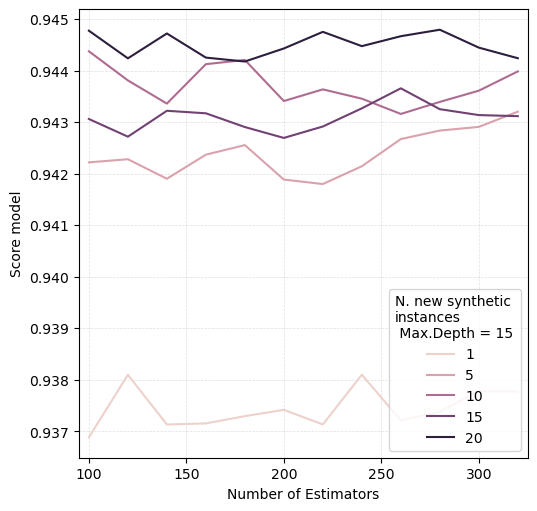

In [16]:
numeric_score_perturb_train_val_tot = [score[1] for score in score_perturb_train_val_tot]

fig, (ax) = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6, 5))
sns.lineplot(x=num_estimators_tot, y=numeric_score_perturb_train_val_tot, hue=n_pert_tot)
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Score model')
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
ax.legend(title='N. new synthetic \ninstances\n Max.Depth = 15', loc='lower right')
ax.set_xlim(95,325)
ax.set_box_aspect(1)
#plt.savefig('Figures/'+'n_perturbations_n_estimators'+output+ ('_cpx_only' if cpx_only else '_cpx_liq') + ('_pwlr_' if pwlt else '_') +'.pdf', format='pdf')

## Train & Test

## Train

In [9]:
# Hyperparameters
n_perturbations_train = 15
n_estimators_ET = 200
max_depth_ET = 15
n_estimators_RF = 3
max_depth_RF = 16
bias_split = 4

In [10]:
start=datetime.now() 

train_2_size = 0.2
X_train_1, X_train_2, y_train_1, y_train_2, train_index_1, train_index_2 = balanced_train_test(X,y,bins,train_2_size, sample_names)


X_train_perturb_1, y_train_perturb_1, groups_train_1 = perturbation(X_train_1
                                                              ,y_train_1
                                                              ,std_dev_perc
                                                              ,n_perturbations=n_perturbations_train)

X_train_perturb_2, y_train_perturb_2, groups_train_2 = perturbation(X_train_2
                                                              ,y_train_2
                                                              ,std_dev_perc
                                                              ,n_perturbations=n_perturbations_train)

if pwlt:
    X_train_perturb_s_1 = pwlt_transformation(X_train_perturb_1)
    X_train_s_1 = pwlt_transformation(X_train_1)
    
    X_train_perturb_s_2 = pwlt_transformation(X_train_perturb_2)
    X_train_s_2 = pwlt_transformation(X_train_2)
else:
    X_train_perturb_s_1 = scaler.transform(X_train_perturb_1)
    X_train_s_1 = scaler.transform(X_train_1)
    
    X_train_perturb_s_2 = scaler.transform(X_train_perturb_2)
    X_train_s_2 = scaler.transform(X_train_2)
    

model_perturb = ExtraTreesRegressor(n_estimators=n_estimators_ET, max_depth=max_depth_ET)
model_perturb.fit(X_train_perturb_s_1,y_train_perturb_1)

model = ExtraTreesRegressor(n_estimators=n_estimators_ET, max_depth=max_depth_ET)
model.fit(X_train_s_1,y_train_1)

print(datetime.now()-start)  


0:00:04.875059


In [11]:
if bias: 
        
    popt_bias_perturb_I, popt_bias_perturb_II, ang_left, ang_right =  piecewise_line(bias_split,
                                                                                     X_train_perturb_s_2,
                                                                                     y_train_perturb_2,
                                                                                     model_perturb)
    popt_bias_I, popt_bias_II, ang_left, ang_right =  piecewise_line(bias_split,
                                                                     X_train_s_2,
                                                                     y_train_2,
                                                                     model)
    
    bias_perturb_params = {
    'slope' :
        {
            'left' : popt_bias_I.tolist(),
            'right' : popt_bias_II.tolist()
        },
    'angle' :
        {
            'left' : ang_left,
            'right' : ang_right
        }
    }
    
    # To save params of bias function
    json_bias = json.dumps(bias_perturb_params)
    
   

## Feature importance

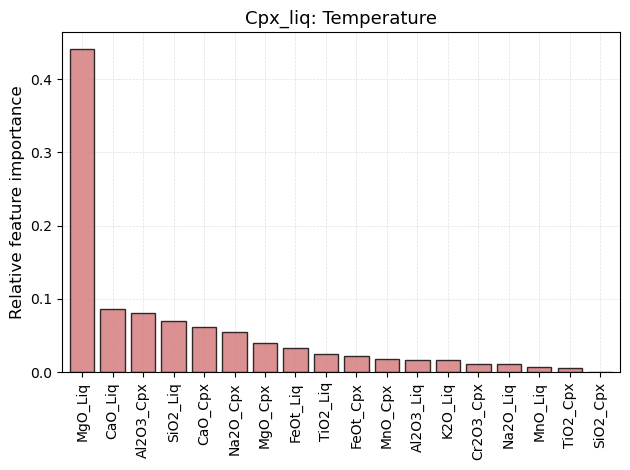

In [12]:
My_color = '#9BB0C1' if output == 'Pressure' else '#D37676'

importance_model_perturb = model_perturb.feature_importances_
forest_importances = pd.Series(importance_model_perturb, index=columns_name).sort_values(ascending=False)# works for no pwlr models

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, color=My_color, alpha = 0.8,
                            edgecolor='black', width=0.8, zorder=2) #P=4CA8B1 T=3F8DF7
ax.set_title(('Cpx: ' if cpx_only else 'Cpx_liq: ')+output, fontsize=13)
ax.set_ylabel("Relative feature importance",fontsize=12)
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4, zorder=1)
fig.tight_layout()
#plt.savefig('Figures/'+'Feature_importance'+('_cpx_only' if cpx_only else '_cpx_liq') + ('_bc_' if bias else '_')+ output+ '.pdf', format='pdf', transparent=True)


## Test

### Input bounds

In [13]:
df_bound = df_init[df_init['Sample_ID'].isin(test_index)]

if cpx_only == True and output == 'Pressure':
    pred_max_bound = np.ones(len(X_test)) * 30.000000
    pred_min_bound = np.ones(len(X_test)) * 0.00000
    warning = df_bound.apply(lambda x: '' if 0.250000<=x['Al2O3_Cpx']<=25.760000
                                              and 0.000137<=x['Na2O_Cpx']<=7.760000
                                              and 0.400000<=x['CaO_Cpx']<=24.820000
                                          else 'Input out of bound', axis=1) 
elif cpx_only == False and output == 'Pressure':
    pred_max_bound = np.ones(len(X_test)) * 30.000000
    pred_min_bound = np.ones(len(X_test)) * 0.00000
    warning = df_bound.apply(lambda x: '' if 0.250000<=x['Al2O3_Cpx']<=25.760000
                                              and 0.000137<=x['Na2O_Cpx']<=7.760000
                                              and 0.030000<=x['MgO_Liq']<=18.587513
                                          else 'Input out of bound', axis=1) 
elif cpx_only == True and output == 'Temperature':
    pred_max_bound = np.ones(len(X_test)) * 1700.000000
    pred_min_bound = np.ones(len(X_test)) * 700.000000
    warning = df_bound.apply(lambda x: '' if 0.760000<=x['MgO_Cpx']<=31.300000
                                              and 0.400000<=x['CaO_Cpx']<=24.820000
                                              and 0.290000<=x['Al2O3_Cpx']<=19.010000
                                              and 1.700000<=x['FeOt_Cpx']<=34.200000
                                              and 0.000179<=x['MnO_Cpx']<=2.980000
                                          else 'Input out of bound', axis=1)
elif cpx_only == False and output == 'Temperature':
    pred_max_bound = np.ones(len(X_test)) * 1700.000000
    pred_min_bound = np.ones(len(X_test)) * 700.000000
    warning = df_bound.apply(lambda x: '' if 0.030000<=x['MgO_Liq']<=17.723561
                                          else 'Input out of bound', axis=1)

### Test as Montecarlo simulation

In [14]:
y_perturb_pred = model_perturb.predict(X_test_perturb_s)
y_pred = model.predict(X_test_perturb_s)

score_perturb_RMSE = MSE(y_test_perturb, y_perturb_pred, squared=False)
score_RMSE = MSE(y_test_perturb, y_pred, squared=False)

lin_res_perturb = st.linregress(y_test_perturb, y_perturb_pred)
lin_res = st.linregress(y_test_perturb, y_pred)

r2_perturb = lin_res_perturb .rvalue**2
slope_perturb = lin_res_perturb .slope
int_perturb = lin_res_perturb .intercept

r2 = lin_res.rvalue**2
slope = lin_res.slope
int = lin_res.intercept


print('Test Monte Carlo')
print('Model-perturb')
print('      R^2: ',r2_perturb)
print('      Intercept: ',int_perturb)
print('      Slope: ',slope_perturb)
print('      RMSE: ',score_perturb_RMSE)

print('Model')
print('      R^2: ',r2)
print('      Intercept: ',int)
print('      Slope: ',slope)
print('      RMSE: ',score_RMSE)



unique_y_perturb_pred = np.apply_along_axis(np.median,1, np.split(y_perturb_pred,len(y_perturb_pred)/p))
unique_y_pred = np.apply_along_axis(np.median,1, np.split(y_pred,len(y_pred)/p))

unique_y_perturb_error_maxPerc = np.apply_along_axis(max_perc,1, np.split(y_perturb_pred,len(y_perturb_pred)/p))
unique_y_perturb_error_minPerc = np.apply_along_axis(min_perc,1, np.split(y_perturb_pred,len(y_perturb_pred)/p))
unique_y_error_maxPerc = np.apply_along_axis(max_perc,1, np.split(y_perturb_pred,len(y_pred)/p))
unique_y_error_minPerc = np.apply_along_axis(min_perc,1, np.split(y_perturb_pred,len(y_pred)/p))

if bias:
        
    bias_perturb_temp = bias_f(unique_y_perturb_pred, 
                               ang_left, popt_bias_perturb_I, 
                               ang_right, popt_bias_perturb_II)
    bias_temp = bias_f(unique_y_pred,
                       ang_left, popt_bias_I, 
                       ang_right, popt_bias_II)
    
    
    unique_y_perturb_pred_temp = unique_y_perturb_pred - bias_perturb_temp
    unique_y_pred_temp = unique_y_pred - bias_temp
    
    unique_y_perturb_error_maxPerc_temp =unique_y_perturb_error_maxPerc - bias_perturb_temp   
    unique_y_perturb_error_minPerc_temp =unique_y_perturb_error_minPerc - bias_perturb_temp
    unique_y_error_maxPerc_temp = unique_y_error_maxPerc - bias_temp
    unique_y_error_minPerc_temp = unique_y_error_minPerc - bias_temp
        
    unique_y_perturb_pred = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_perturb_pred_temp))
    unique_y_pred = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_pred_temp))
    
    unique_y_perturb_error_maxPerc = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_perturb_error_maxPerc_temp))
    unique_y_perturb_error_minPerc = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_perturb_error_minPerc_temp))
    unique_y_error_maxPerc = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_error_maxPerc_temp))
    unique_y_error_minPerc = np.minimum(pred_max_bound, np.maximum(pred_min_bound, unique_y_error_minPerc_temp))
    
    
predictions = pd.DataFrame(data=np.transpose(np.array([unique_y_perturb_pred
                                                       ,unique_y_perturb_error_maxPerc
                                                       ,unique_y_perturb_error_minPerc
                                                       ,unique_y_pred
                                                       ,unique_y_error_maxPerc
                                                       ,unique_y_error_minPerc
                                                       ,y_test
                                                       ,warning])),    
             index=test_index,
             columns=['Pred_perturb'
                      ,'Error_perturb_maxPerc'
                      ,'Error_perturb_minPerc'
                      ,'Pred'
                      ,'Error_maxPerc'
                      ,'Error_minPerc'
                      ,'Real_value'
                      ,'Warning'])  


score_perturb_RMSE_median = MSE(y_test, unique_y_perturb_pred, squared=False)
lin_res_perturb_median = st.linregress(y_test, unique_y_perturb_pred)
r2_perturb_median = lin_res_perturb_median.rvalue**2
slope_perturb_median = lin_res_perturb_median.slope
int_perturb_median = lin_res_perturb_median.intercept




print('Model-perturb-median')
print('      R^2: ',r2_perturb_median)
print('      Intercept: ',int_perturb_median)
print('      Slope: ',slope_perturb_median)
print('      RMSE: ',score_perturb_RMSE_median)


print('Predictions')
print(predictions.head())

Test Monte Carlo
Model-perturb
      R^2:  0.9464203527874382
      Intercept:  96.15971773002525
      Slope:  0.9178343368925405
      RMSE:  36.109283243866585
Model
      R^2:  0.9411525729807038
      Intercept:  105.15816095717287
      Slope:  0.9107156710768263
      RMSE:  37.8902219530946
Model-perturb-median
      R^2:  0.9473575265112488
      Intercept:  53.76992511371077
      Slope:  0.9551843139035331
      RMSE:  35.56302164938024
Predictions
     Pred_perturb Error_perturb_maxPerc Error_perturb_minPerc         Pred  \
230    1152.07494           1162.214283           1142.540394  1164.391395   
1905  1287.664647           1294.443198           1279.420725  1288.961521   
1461   890.600428             893.06691            887.956502   881.551953   
1954    907.24459             911.53721            902.381949   905.855905   
1972  1316.085654           1320.678904           1311.307135    1312.1725   

     Error_maxPerc Error_minPerc Real_value Warning  
230    1162.2

## Evaluation

In [15]:
My_color = '#9BB0C1' if output == 'Pressure' else '#D37676'
My_ecolor = 'grey' 
unit = 'kbar' if output == 'Pressure' else '°C'
width =1 if output=='Pressure' else 25
inc = 1 if output=='Pressure' else 35 
inc_top  = 3 if output=='Pressure' else 90
a= 3 if output=='Pressure' else 1
ylim = 6 if output=='Pressure' else 100 
ylim_l = 3 if output=='Pressure' else 100
facecolor = '#35374B' if output=='Pressure' else '#7D0A0A'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


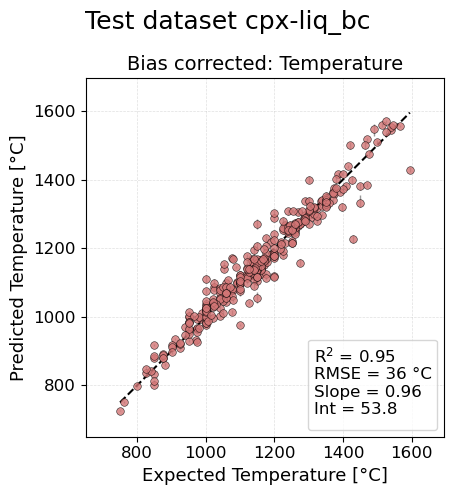

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=1, constrained_layout=True, figsize=(5, 5))

fig.suptitle('Test dataset' + (' cpx' if cpx_only else ' cpx-liq') + ('_bc' if bias else ' '), fontsize=18)  

ax.errorbar(y_test, unique_y_perturb_pred,
            yerr=[unique_y_perturb_pred-unique_y_perturb_error_minPerc,
                  unique_y_perturb_error_maxPerc-unique_y_perturb_pred],
            linestyle='', marker = 'o',capsize=0,
             color = My_color, markersize = 5.5, markeredgecolor='black',markeredgewidth=0.4,elinewidth=1,
             ecolor = My_ecolor, alpha = 0.8)

ax.plot((np.min(y_test),np.max(y_test)),
        (np.min(y_test),np.max(y_test)), linestyle = '--', color ='black')

ax.set_xlim(np.min(y_test)-ylim_l,np.max(y_test)+ylim)
ax.set_ylim(np.min(y_test)-ylim_l,np.max(y_test)+ylim)
ax.set_xlabel('Expected '+output +' ['+unit+']',fontsize=13)
ax.set_ylabel('Predicted '+output+' ['+unit+']',fontsize=13)
ax.set_title(('Bias corrected: ' if bias else 'No Bias corrected: ')+output, fontsize=14)
ax.legend(title = r'R$^2$ = {:.2f}'.format(r2_perturb_median) + '\n' +  
                  ('RMSE = {:.0f} ' if output == 'Temperature' else 'RMSE = {:.1f} ').format(score_perturb_RMSE_median) + unit + '\n' + 
                  'Slope = {:.2f}'.format(slope_perturb_median) + '\n' + 
                  'Int = {:.1f}'.format(int_perturb_median), loc='lower right', title_fontsize=12) 

ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_box_aspect(1)
plt.tight_layout()
#plt.savefig('Figures/'+'Test_predictions' +('_cpx_only' if cpx_only else '_cpx_liq') + ('_bc_' if bias else '_')+ output+ '.pdf', format='pdf', transparent=True)


#### Sectioning

Metrics for Interval 1: 54.096462309304
Metrics for Interval 4: -32.520328895363946


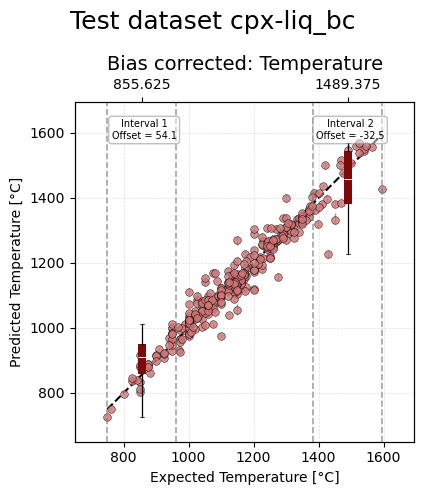

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=1, constrained_layout=True, figsize=(5, 5))

fig.suptitle('Test dataset' + (' cpx' if cpx_only else ' cpx-liq') + ('_bc' if bias else ' '), fontsize=18) 

ax.errorbar(y_test, unique_y_perturb_pred,
            yerr=[unique_y_perturb_pred-unique_y_perturb_error_minPerc,
                  unique_y_perturb_error_maxPerc-unique_y_perturb_pred],
            linestyle='', marker = 'o',capsize=0,
             color = My_color, markersize = 5.5, markeredgecolor='black',markeredgewidth=0.4,elinewidth=1,
             ecolor = My_ecolor, alpha = 0.8, zorder= 1)

ax.plot((np.min(y_test),np.max(y_test)),
        (np.min(y_test),np.max(y_test)), linestyle = '--', color ='black',  zorder= 0)


ax.set_xlim(np.min(y_test)-ylim_l,np.max(y_test)+ylim)
ax.set_ylim(np.min(y_test)-ylim_l,np.max(y_test)+ylim)

# Create a second axis for box plots
ax.grid(color='#B2B2B2', linestyle='--', linewidth=0.5, alpha=0.4)
ax2 = ax.twiny()

# Create intervals
interval_1 = (np.min(y_test), 
             min(y_train_perturb_2)+(1*(max(y_train_perturb_2)-min(y_train_perturb_2))/(a*bias_split)))
interval_4 = (max(y_train_perturb_2)-(1*(max(y_train_perturb_2)-min(y_train_perturb_2))/(a*bias_split)), 
              np.max(y_test))


# Filter data points within each interval
data_interval_1 = unique_y_perturb_pred[(y_test >= interval_1[0]) & (y_test <= interval_1[1])]
data_interval_4 = unique_y_perturb_pred[(y_test >= interval_4[0]) & (y_test <= interval_4[1])]

# Create box plots
boxprops     = dict(linestyle='-', linewidth=0.0, color='black', facecolor=facecolor, alpha = 1)
medianprops  = dict(linestyle='-', linewidth=0.7, color='white')
whiskerprops = dict(linestyle='-', linewidth=0.9, color='black')
capprops     = dict(linestyle='-', linewidth=0.5, color='black')

ax2.boxplot([data_interval_1, data_interval_4],
           positions=[interval_1[0]+((interval_1[1]-interval_1[0])/2), 
                      interval_4[0]+((interval_4[1]-interval_4[0])/2)],
           widths=width, showfliers=False,
           boxprops=boxprops, medianprops=medianprops,
           whiskerprops=whiskerprops, capprops=capprops,patch_artist=True, zorder= 2)


# Function to calculate metrics
def calculate_offset(median_pred, y_true_position):
    offset = median_pred-y_true_position
    return  offset

# Calculate metrics for each interval
offset_interval_1 = calculate_offset(np.median(unique_y_perturb_pred[(y_test >= interval_1[0]) & (y_test <= interval_1[1])]),
                                       interval_1[0]+((interval_1[1]-interval_1[0])/2))

offset_interval_4 = calculate_offset(np.median(unique_y_perturb_pred[(y_test >= interval_4[0]) & (y_test <= interval_4[1])]),
                                       interval_4[0]+((interval_4[1]-interval_4[0])/2))

# Display or use the metrics as needed
print("Metrics for Interval 1:", offset_interval_1)
print("Metrics for Interval 4:", offset_interval_4)


# Add legends for each interval
font_size = 7
ax2.annotate(f"Interval 1\nOffset = {offset_interval_1:.1f}",
             xy=(interval_1[0]+((interval_1[1]-interval_1[0])/2)-inc, np.max(y_test)+ inc_top),
             xytext=(10, -10),
             textcoords="offset points",
             ha='center', va='top',
             bbox=dict(boxstyle='round', alpha=0.5, facecolor='white',edgecolor='grey'),fontsize=font_size)
          
ax2.annotate(f"Interval 2\nOffset = {offset_interval_4:.1f}",
             xy=(interval_4[0]+((interval_4[1]-interval_4[0])/2)-inc, np.max(y_test)+ inc_top),
             xytext=(10, -10),
             textcoords="offset points",
             ha='center', va='top',
             bbox=dict(boxstyle='round', alpha=0.5, facecolor='white',edgecolor='grey'),fontsize=font_size)


ax2.axvline(x=interval_1[0],linestyle='--', linewidth=1.2, color='#7D7C7C', alpha=0.7)
ax2.axvline(x=interval_1[1],linestyle='--', linewidth=1.2, color='#7D7C7C', alpha=0.7)
ax2.axvline(x=interval_4[0],linestyle='--', linewidth=1.2, color='#7D7C7C', alpha=0.7)
ax2.axvline(x=interval_4[1],linestyle='--', linewidth=1.2, color='#7D7C7C', alpha=0.7)

ax2.set_xlim(np.min(y_test)-ylim_l,np.max(y_test)+ylim)
ax2.set_ylim(np.min(y_test)-ylim_l,np.max(y_test)+ylim)


ax.set_xlabel('Expected '+output +' ['+unit+']')
ax.set_ylabel('Predicted '+output +' ['+unit+']')
ax.set_title(('Bias corrected: ' if bias else 'No Bias corrected: ')+output, fontsize=14)

ax.set_box_aspect(1)

plt.tight_layout()
#plt.savefig('Figures/'+'Test_predictions' +('_cpx_only' if cpx_only else '_cpx_liq') + ('_bc_' if bias else '_')+ output+ '_boxplots.pdf', format='pdf', transparent=True)


# Saving

In [ ]:

initial_type = [('float_input', FloatTensorType([None, X_train_perturb_s_1.shape[1]]))] 
model_onx = convert_sklearn(model_perturb, initial_types=initial_type,target_opset=12)

 
if output == 'Pressure' and cpx_only and bias ==True:
    with open("models/"+"Model_cpx_only_P_bias.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
    with open("models/"+"Model_cpx_only_P_bias.json", "w") as outfile:
            json.dump(json_bias, outfile)
    with open("models/"+"Model_cpx_only_P_bias.joblib", "wb") as outfile:
            joblib.dump(scaler, outfile)
  
    
elif output == 'Temperature' and cpx_only and bias ==True:
    with open("models/"+"Model_cpx_only_T_bias.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
    with open("models/"+"Model_cpx_only_T_bias.json", "w") as outfile:
        json.dump(json_bias, outfile)
    with open("models/"+"Model_cpx_only_T_bias.joblib", "wb") as outfile:
            joblib.dump(scaler, outfile)


elif output == 'Pressure' and cpx_only==False and bias ==True:
    with open("models/"+"Model_cpx_liquid_P_bias.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
        with open("models/"+"Model_cpx_liquid_P_bias.json", "w") as outfile:
            json.dump(json_bias, outfile)
        with open("models/"+"Model_cpx_liquid_P_bias.joblib", "wb") as outfile:
            joblib.dump(scaler, outfile)

elif output == 'Temperature' and cpx_only==False and bias ==True:
    with open("models/"+"Model_cpx_liquid_T_bias.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
        with open("models/"+"Model_cpx_liquid_T_bias.json", "w") as outfile:
            json.dump(json_bias, outfile)
        with open("models/"+"Model_cpx_liquid_T_bias.joblib", "wb") as outfile:
            joblib.dump(scaler, outfile)
    
            
#No bias   
elif output == 'Pressure' and cpx_only and bias ==False:
    with open("models/"+"Model_cpx_only_P.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
    with open("models/"+"Model_cpx_only_P.joblib", "wb") as outfile:
        joblib.dump(scaler, outfile)
        
elif output == 'Temperature' and cpx_only and bias ==False:
    with open("models/"+"Model_cpx_only_T.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
    with open("models/"+"Model_cpx_only_T.joblib", "wb") as outfile:
        joblib.dump(scaler, outfile)

elif output == 'Pressure' and cpx_only==False and bias ==False:
    with open("models/"+"Model_cpx_liq_P.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
    with open("models/"+"Model_cpx_liq_P.joblib", "wb") as outfile:
        joblib.dump(scaler, outfile)
  
elif output == 'Temperature' and cpx_only==False and bias ==False:
    with open("models/"+"Model_cpx_liq_T.onnx", "wb") as f:
        f.write(model_onx.SerializeToString())
    with open("models/"+"Model_cpx_liq_T.joblib", "wb") as outfile:
        joblib.dump(scaler, outfile)

else:
    print('We can just manage Pressure or Temperature')

